In [1]:
import numpy as np

from matplotlib import pyplot as plt

In [2]:
x = np.linspace(-1,1,50)
y1 = np.sqrt(1-x**2)
y2 = -y1

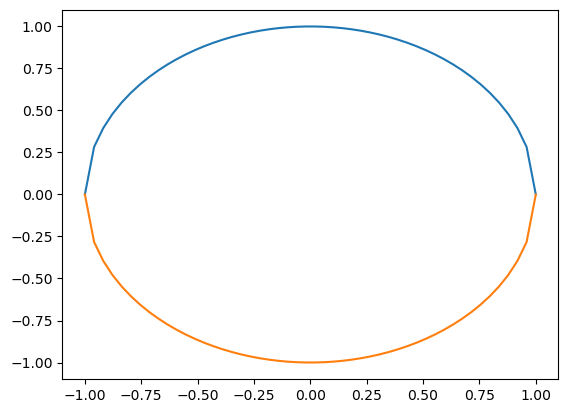

In [3]:
plt.plot(x,y1)
plt.plot(x,y2)

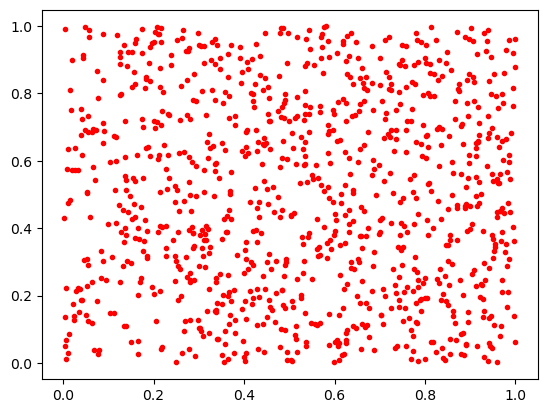

In [10]:
n = 1000

x = np.random.random(n)
y = np.random.random(n)

plt.plot(x, y, 'r.')

In [11]:
r = np.sqrt(x**2 + y**2)

In [12]:
inside = np.where(r <= 1, True, False)
outside = ~inside

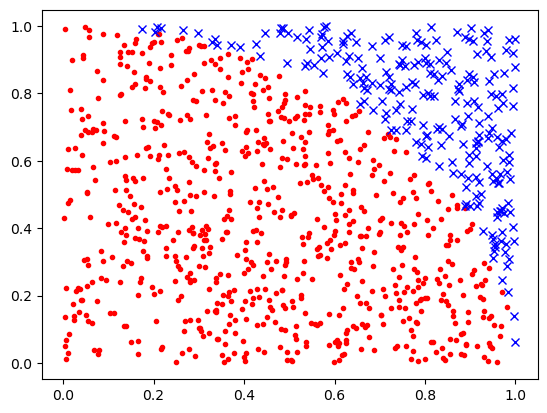

In [13]:
plt.plot(x[inside], y[inside], 'r.')
plt.plot(x[outside], y[outside], 'bx')

In [14]:
num_inside = np.sum(inside)

A = num_inside / n
pi = 4*A
print(pi)

3.048


In [33]:
import pycuda.autoinit
import pycuda.driver as cuda
import numpy
import time

from pycuda.compiler import SourceModule

mod = SourceModule("""
__global__ void cudaPI(float* dest) {
    // find global index of thread in x- and y-dimension
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    
    // linearized (1D) global index of thread
    int idx = i + j*(gridDim.x * blockDim.x);
    
    // compute distance between threads
    // (each thread representing one point placed on the 1st "unit circle quadrant", see image above)
    float dx = 1.0f / (float) (gridDim.x * blockDim.x);
    float dy = 1.0f / (float) (gridDim.y * blockDim.y);
    
    // compute x- and y-coordinates between 0.0 and 1.0
    float x = i*dx;
    float y = j*dy;
    
    // is the point inside the unit circle or not?
    int inside = 0;
    if (x * x + y * y < 1.0f) {
        // point is inside circle!
        ++inside;
    }
    dest[idx] = inside;
}
""")
start_t = time.time()

cudaPI = mod.get_function("cudaPI")

grid = (1000, 1000)
block = (10, 10, 1)


nx = grid[0]*block[0]
ny = grid[1]*block[1]
      
results = numpy.zeros(nx*ny).astype(numpy.float32)

cudaPI(cuda.Out(results),
        block=block, grid=grid)

cuda_end = time.time()
print("Cuda end: {0}".format(cuda_end-start_t))
# sum up results from each CUDA-thread
k = 0.0;
for i in range(0,len(results)):
    k += results[i];

# calculate final result
n = nx*ny
pi = 4 * (k / n)

print(n)
print(k)
print("PI is (approximately): " + str(pi))
print("End time: {0}".format(time.time()-start_t))

Cuda end: 0.09609508514404297
100000000
78549764.0
PI is (approximately): 3.14199056
End time: 29.701080799102783
